In [1]:
import numpy as np

def spectral_slope(f, E, fmin, fmax):
    """
    Function for computing the spectral slope in log space of a power spectral
    density function within a specified frequency subrange.

    Parameters
    ----------
    f : ndarray
        Cyclical frequencies corresponding to the PSD.
    E : ndarray
        Normalized power spectral density function.
    fmin : float
        Lower frequency limit for subrange.
    fmax : float
        Upper frequency limit for subrange.

    Returns
    -------
    m : float
        Spectral slope (slope of log-log linear fit).
    mm : float
        Uncertainty of the spectral slope.
    yfit : ndarray
        Fitted PSD values in linear space.
    f_range : ndarray
        Frequency subrange in linear space.
    """

    # Select frequency subrange
    idx = (f >= fmin) & (f <= fmax) & np.isfinite(f) & np.isfinite(E)
    fi = np.log10(f[idx])
    Ei = np.log10(E[idx])
    
    # Least squares fit (linear regression in log-log space)
    A = np.vstack([np.ones_like(fi), fi]).T
    coef, residuals, _, _ = np.linalg.lstsq(A, Ei, rcond=None)
    m = coef[1]
    
    # Fitted values in log space
    yfit_log = A @ coef
    yfit = 10**yfit_log
    f_range = 10**fi

    # Uncertainty estimation
    M = len(Ei)
    parameters = 2
    if M <= parameters:
        mm = np.nan
    else:
        # Uncertainty in log-log space residuals
        residual_var = np.sum((Ei - yfit_log)**2) / (M - parameters)
        sigma_data_log = np.sqrt(residual_var)

        delta = M * np.sum(f_range**2) - (np.sum(f_range))**2
        mm = sigma_data_log * np.sqrt(M / delta)

    return m, mm, yfit, f_range


Estimated spectral slope: -5.80 ± 1.00 (true: -5)


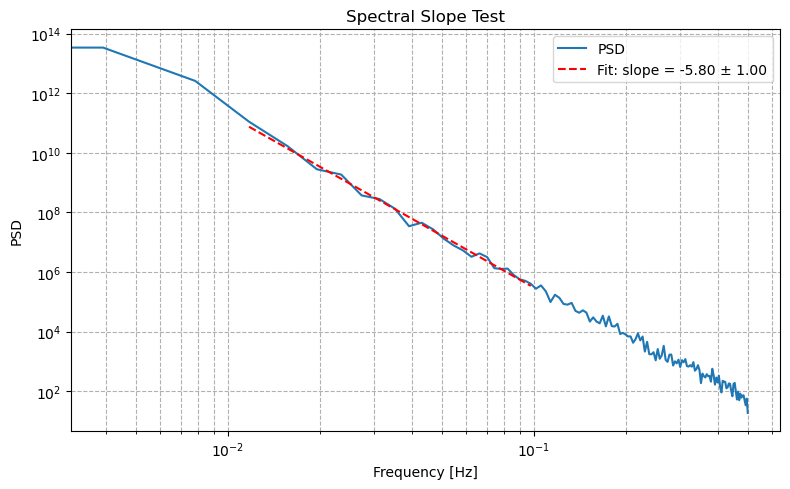

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Import your spectral_slope function
# from your_module import spectral_slope  # Uncomment if it's in a module

# Define parameters
np.random.seed(42)  # For reproducibility
N = 1024  # Number of time points
dt = 1.0  # Time step
t = np.arange(N) * dt

# Create synthetic signal with a power-law spectrum (slope ~ -2)
# Generate white noise, filter it in frequency domain
sigma = 1
white_noise = sigma * np.random.randn(N)
freq = np.fft.rfftfreq(N, d=dt)
spectrum = np.fft.rfft(white_noise)

# Apply a power-law decay in frequency domain
true_slope = -5
power_law = (freq[1:]**true_slope)
power_law = np.insert(power_law, 0, power_law[0])  # Avoid 0 frequency issue
spectrum_filtered = spectrum * power_law**0.5
signal = np.fft.irfft(spectrum_filtered, n=N)

# Compute PSD (using Welch's method)
from scipy.signal import welch
f, E = welch(signal, fs=1/dt, nperseg=256)

# Define frequency range for slope fitting
fmin = 0.01
fmax = 0.1

# Run spectral slope analysis
m, mm, yfit, f_range = spectral_slope(f, E, fmin, fmax)

# Print results
print(f"Estimated spectral slope: {m:.2f} ± {mm:.2f} (true: {true_slope})")

# Plot
plt.figure(figsize=(8, 5))
plt.loglog(f, E, label='PSD')
plt.loglog(f_range, yfit, '--r', label=f'Fit: slope = {m:.2f} ± {mm:.2f}')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.title('Spectral Slope Test')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()
